## Titanic Project
'Titanic: Machine Learning from Disaster' is the first thing you will see in the kaggle competition. This dataset is also widely used as an introductory example for machine learning online courses. <br><br> For those who are interested in doing by themselves, the dataset could be easily found here: https://www.kaggle.com/c/titanic/data

Let's take a look at the data description.
### Description of the dataset
The data has been split into two groups:
- training set (train.csv)
- test set (test.csv)

#### Variable Table
| Variable |                 Definition                 |                       Key                      |
|:--------:|:------------------------------------------:|:----------------------------------------------:|
| survival |                  Survival                  |                 0 = No, 1 = Yes                |
|  pclass  |                Ticket class                |            1 = 1st, 2 = 2nd, 3 = 3rd           |
|    sex   |                     Sex                    |                                                |
|    age   |                Age in years                |                                                |
|   sibsp  | # of siblings / spouses aboard the Titanic |                                                |
|   parch  | # of parents / children aboard the Titanic |                                                |
|  ticket  |                Ticket number               |                                                |
|   fare   |               Passenger fare               |                                                |
|   cabin  |                Cabin number                |                                                |
| embarked |             Port of Embarkation            | C = Cherbourg, Q = Queenstown, S = Southampton |

#### Variable Notes

>pclass: Levels for socio-economic status
>> 1st = Upper<br>
>> 2nd = Middle<br>
>> 3rd = Lower

>age: Age is fractional if less than 1

>sibsp: The dataset defines family relations as <br>
>>Sibling = brother, sister, stepbrother, stepsister<br>
>>Spouse = husband, wife (mistresses and fiancés were ignored)

>parch: The dataset defines family relations as <br>
>>Parent = mother, father <br>
>>Child = daughter, son, stepdaughter, stepson<br>
>> * Some children travelled only with a nanny, therefore parch=0 for them.

### The Objective
We are tasked to analyze what sorts of people were likely to survive and to predict which passengers survived the tragedy applying the tools of machine learning.

In [5]:
%matplotlib inline  
%config InlineBackend.figure_format='retina'

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [6]:
train_set = pd.read_csv('new_train.csv')
test_set = pd.read_csv('new_test.csv')
dataset = [train_set, test_set]

In [7]:
passengerId = test_set.PassengerId
for data in dataset:
    data.drop(['FareGroup','PassengerId'], axis = 1, inplace = True)
    
test_set.drop(['Survived'], axis = 1, inplace = True)

In [8]:
train_set.head()

,Embarked,Fare,Pclass,Sex,Survived,Title,Count,AgeGroup,GroupSize
0,S,7.25000,3,male,0.0,Mr,1,Adult,2
1,C,35.64165,1,female,1.0,Mrs,2,Adult,2
2,S,7.92500,3,female,1.0,Miss,1,Adult,1
3,S,26.55000,1,female,1.0,Mrs,2,Adult,2
4,S,8.05000,3,male,0.0,Mr,1,Adult,1


In [9]:
# Create Dummy Variables, Add to full, and Remove Original Ones
def create_dummies(data) :
    df = data
    global df
    sex = pd.get_dummies(df.Sex , prefix = 'Sex_')
    embarked = pd.get_dummies(df.Embarked , prefix= 'Embarked_' )
    title = pd.get_dummies(df.Title , prefix= 'Title_' )
#    groupSize = pd.get_dummies(df.GroupSize, prefix = 'GroupSize_')
    ageGroup = pd.get_dummies(df.AgeGroup, prefix = 'AgeGroup_')
    pclass = pd.get_dummies(df.Pclass, prefix = 'Pclass')

    df = pd.concat([df, sex, embarked, title, pclass, ageGroup], axis = 1)
    df.drop(['Sex','Embarked','Title','Pclass', 'AgeGroup'], axis = 1, inplace = True)
    return df

train = create_dummies(train_set)
test = create_dummies(test_set)

### Logistic Regression (Score = 0.77990)

In [10]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X, y = train.drop('Survived', axis = 1), train.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [11]:
from sklearn.linear_model import LogisticRegression
# Train Logistic Regression
logitModel = LogisticRegression()
logitModel.fit(X_train, y_train)

# Prediction
y_pred = logitModel.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(logitModel.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.825


#### Parameter Tuning

In [12]:
tol = [0.001, 0.01, 0.1, 1, 10, 100]
lassoScore, ridgeScore = [], []

for i in range(len(tol)):
    logitModel = LogisticRegression(penalty= 'l1', tol = tol[i])
    logitModel.fit(X_train, y_train)
    ridgeScore.append(logitModel.score(X_test, y_test))
    
    logitModel = LogisticRegression(penalty= 'l2', tol = tol[i])
    logitModel.fit(X_train, y_train)
    lassoScore.append(logitModel.score(X_test, y_test))

print('Best Logistic regression classifier on test set with ridge penalty: {:.3f}(C = {})'.format(max(ridgeScore), tol[ridgeScore.index(max(ridgeScore))]))
print('Best Logistic regression classifier on test set with lasso penalty: {:.3f}(C = {})'.format(max(lassoScore), tol[lassoScore.index(max(lassoScore))]))

Best Logistic regression classifier on test set with ridge penalty: 0.825(C = 0.001)
Best Logistic regression classifier on test set with lasso penalty: 0.825(C = 0.001)


In [13]:
logitModel = LogisticRegression(penalty= 'l2', tol = 0.001)
logitModel.fit(X_train, y_train)
Survived = pd.DataFrame(logitModel.predict(test).astype(int))

In [14]:
submission = pd.concat([passengerId, Survived], axis = 1)
submission.to_csv('Submission(logit).csv', index = False)

### RandomForest (Score = 0.78468)

In [15]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
clf_rf.score(X_test, y_test)

0.79477611940298509

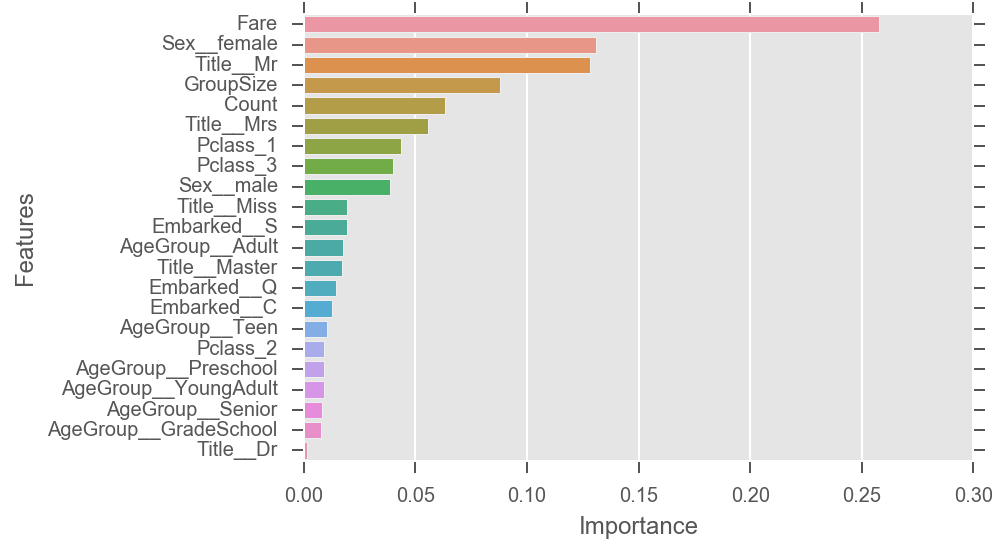

In [16]:
impvar = pd.DataFrame()
impvar['Features'], impvar['Importance'] = X_train.columns.values, clf_rf.feature_importances_
impvar.sort_values(by = 'Importance', ascending = False, inplace = True)
sns.barplot(x = 'Importance', y = 'Features', data = impvar, orient = "h")

In [ ]:
from sklearn.feature_selection import SelectFromModel
reduced = SelectFromModel(clf_rf, prefit=True)
X_train_reduced, X_test_reduced = reduced.transform(X_train), reduced.transform(X_test)
test_reduced = reduced.transform(test)

clf_rf.reduced = RandomForestClassifier()
clf_rf.reduced.fit(X_train_reduced, y_train)
clf_rf.reduced.score(X_test_reduced, y_test)

#### Parameter Tuning

In [17]:
parameter_grid = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [250, 375, 500],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_leaf': [1, 3, 5],
                 'bootstrap': [True, False],
                 "criterion": ["gini", "entropy"]
                 }

grid_search = GridSearchCV(clf_rf, param_grid= parameter_grid, scoring = 'accuracy')

NameError: name 'GridSearchCV' is not defined

In [170]:
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Test score: {}'.format(grid_search.score(X_test, y_test)))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8250401284109149
Test score: 0.8134328358208955
Best parameters: {'max_depth': 4, 'min_samples_leaf': 3, 'n_estimators': 375, 'criterion': 'gini', 'max_features': 'auto', 'bootstrap': False}


In [171]:
clf_rf = RandomForestClassifier(**grid_search.best_params_)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=375, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [177]:
Survived = pd.DataFrame(clf_rf.predict(test).astype(int))
submission = pd.concat([passengerId, Survived], axis = 1).rename(columns = {0 : 'Survived'})
submission.to_csv('Submission(RandomForest).csv', index = False)

### Support Vector Machine (SVM)

In [179]:
# Feature Scaling
# working with reduced data (via randomforest)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_svm, X_test_svm = sc.fit_transform(X_train), sc.transform(X_test)
test_svm = sc.fit_transform(test)

In [180]:
from sklearn.svm import SVC
clf_svm = SVC()
parameter_grid = [
#{'C' : [0.01, 0.1, 1, 10, 100], 'kernel' : ['linear']},
                 {'C' : [0.01, 0.1, 1, 10, 100], 'kernel' : ['rbf'], 'gamma' : [0.5, 0.1, 0.01, 0.001]},
                 {'C' : [0.01, 0.1, 1, 10, 100], 'kernel' : ['poly'], 'gamma' : [0.5, 0.1, 0.01, 0.001], 'degree' : [1,2,3]}]

grid_search = GridSearchCV(estimator = clf_svm, param_grid = parameter_grid, scoring = 'accuracy')

In [ ]:
clf_svm = grid_search.fit(X_train_svm, y_train)
print('Best score: {}'.format(clf_svm.grid_scores_))
print('Test score: {}'.format(clf_svm.score(X_test_svm, y_test)))
print('Best parameters: {}'.format(clf_svm.best_params_))

In [ ]:
clf_svm = SVC(**clf_svm.best_params_)
clf_svm.fit(X_train_svm, y_train)

In [ ]:
Survived = pd.DataFrame(clf_svm.predict(test_svm).astype(int))
submission = pd.concat([passengerId, Survived], axis = 1).rename(columns = {0 : 'Survived'})
submission.to_csv('Submission(SVM).csv', index = False)